In [1]:
import torch
import torch.nn as nn
import math

import numpy as np

In [2]:
class PatchEmbedding(nn.Module):
    """
    Converts images into patches and then projects them into an embedding space.

    Args:
        img_size (int): Size of the input image (assumed to be square)
        patch_size (int): Size of each patch (assumed to be square)
        in_channels (int): Number of input channels (3 for RGB images)
        embed_dim (int): Dimension of the patch embedding
    """

    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        # Number of patches along each dimension
        self.num_patches = (img_size // patch_size) ** 2

        # Convolutional layer for patch extraction and embedding
        # Kernel and stride are both equal to patch_size to ensure non-overlapping patches
        self.proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, X):
        """
        Forward pass to convert image to patch embeddings

        Args:
            X: Input tensor of shape [batch_size, in_channels, img_size, img_size]

        Returns:
            Patch embeddings tensor of shape [batch_size, num_patches, embed_dim]
        """
        B, C, H, W = X.shape
        assert (
            H == W == self.img_size
        ), f"Input image size ({H}*{W}) doesn't match expected size ({self.img_size}*{self.img_size})"
        
        # (B, C, H, W) -> (B, embed_dim, H//patch_size, W//patch_size)
        X = self.proj(X)

        # (B, embed_dim, H', W') -> (B, embed_dim, num_patches)
        X = X.flatten(2)

        # (B, embed_dim, num_patches) -> (B, num_patches, embed_dim)
        X = X.transpose(1, 2)

        return X


class PatchUnembedding(nn.Module):
    """
    Optimized patch unembedding module using transposed convolution.
    """

    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.grid_size = img_size // patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Intermediate patch size (half the original size)
        self.mid_patch_size = patch_size // 2

        # Use a smaller projection first (drastically reduces parameters)
        self.proj = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 4),  # Reduce embedding dimension
            nn.GELU(),
            nn.Linear(
                embed_dim // 4, self.mid_patch_size * self.mid_patch_size
            ),  # Project to smaller patches
        )

        # Transposed convolution for efficient upsampling
        self.upsample = nn.ConvTranspose2d(
            in_channels=1, out_channels=1, kernel_size=2, stride=2, padding=0
        )

    def forward(self, X):
        B, N, D = X.shape

        # Project to smaller dimension patches (much smaller matrix multiplication)
        X = self.proj(X)  # [B, N, mid_patch_size^2]

        # Reshape to spatial representation with smaller patch size
        X = X.reshape(
            B,
            self.grid_size,
            self.grid_size,
            self.in_channels,
            self.mid_patch_size,
            self.mid_patch_size,
        )  # [B, grid_size, grid_size, in_channels, mid_patch_size, mid_patch_size]

        # Reorder to image format
        X = X.permute(
            0, 3, 1, 4, 2, 5
        ).contiguous()  # [B, in_channels, grid_size, mid_patch_size, grid_size, mid_patch_size]

        # Merge grid and patch dimensions
        X = X.reshape(
            B,
            self.in_channels,
            self.grid_size * self.mid_patch_size,
            self.grid_size * self.mid_patch_size,
        )  # [B, in_channels, grid_size*mid_patch_size, grid_size*mid_patch_size]

        # Use transposed convolution for final upsampling
        X = self.upsample(X)  # [B, in_channels, img_size, img_size]
        
        return X


class PositionalEmbedding(nn.Module):
    """
    Adds learnable positional embeddings to the patch embeddings.

    Args:
        num_patches (int): Number of patches
        embed_dim (int): Dimension of the patch embedding
        dropout (float): Dropout rate
    """

    def __init__(self, num_patches, embed_dim=512, dropout=0.1):
        super().__init__()
        self.num_patches = num_patches
        self.embed_dim = embed_dim

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(p=dropout)

        self.initialize_weights()

    def initialize_weights(self):
        """Initialize the positional embeddings using a normal distribution"""
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, X):
        """
        Forward pass to add positional embeddings to patch embeddings

        Args:
            X: Tensor of shape [batch_size, num_patches, embed_dim]

        Returns:
            Tensor of shape [batch_size, num_patches, embed_dim] with positional embeddings added
        """
        X = X + self.pos_embed
        X = self.dropout(X)

        return X


class ImageEmbedding(nn.Module):
    def __init__(
        self, img_size=256, patch_size=16, in_channels=1, embed_dim=512, dropout=0.1
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim,
        )

        self.num_patches = self.patch_embed.num_patches
        self.pos_embed = PositionalEmbedding(
            num_patches=self.num_patches, embed_dim=embed_dim, dropout=dropout
        )

    def forward(self, X):
        X = self.patch_embed(X)
        X = self.pos_embed(X)

        return X

In [3]:
class SinusoidalPosEmb(nn.Module):
    """
    Sinusoidal positional embedding for timesteps
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: (bs, 1)
        Returns:
        - embeddings: (bs, dim)
        """
        freqs = t * self.weights * 2 * math.pi # (bs, half_dim)
        sin_embed = torch.sin(freqs) # (bs, half_dim)
        cos_embed = torch.cos(freqs) # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)


class TimestepEmbedding(nn.Module):
    """
    Embeds timestep values into a higher dimension.
    """
    def __init__(self, dim):
        super().__init__()
        self.sinusoidal_pos_emb = SinusoidalPosEmb(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )
        
    def forward(self, timesteps):
        emb = self.sinusoidal_pos_emb(timesteps)
        return self.mlp(emb)
    
class ModulationEmbedding(nn.Module):
    """
    Combined embedding of timestep and class label for
    AdaLN modulation.
    """
    def __init__(self, dim, num_classes=20):
        super().__init__()
        self.dim = dim
        
        self.time_embedding = TimestepEmbedding(dim)
        self.class_embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=dim)
        
    def forward(self, C, T):
        T = self.time_embedding(T)
        C = self.class_embedding(C)
        
        return C + T

In [4]:

class DiTBlock(nn.Module):
    """
    Diffusion Transformer (DiT) block with cross-attention and AdaLN-FFN.
    
    Args:
        dim (int): The embedding dimension.
        num_heads (int): Number of attention heads.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        dropout (float): Dropout probability.
    """
    def __init__(
        self,
        dim,
        num_heads=8,
        mlp_ratio=4.0,
        dropout=0.1
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        
        self.cross_attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)        
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
        self.adaLN = nn.Sequential(
            nn.SiLU(),
            nn.Linear(dim, 4 * dim, bias=True)
        )
        
    def forward(self, X, Y, C):
        """
        Forward pass of the DiT block.
        
        Args:
            X: Input tensor of shape [batch_size, seq_len, dim].
            Y: Image condition of shape [batch_size, seq_len, dim].
            C: Combined timestep and class label embedding of shape [batch_size, dim].
        
        Returns:
            Output tensor of shape [batch_size, seq_len, dim].
        """
        ada_out = self.adaLN(C)
        
        scale_shift_1, scale_shift_2 = ada_out.chunk(2, dim=1)
        scale_1, shift_1 = scale_shift_1.chunk(2, dim=1)
        scale_2, shift_2 = scale_shift_2.chunk(2, dim=1)

        scale_1 = scale_1.unsqueeze(1)  # [B, 1, D]
        shift_1 = shift_1.unsqueeze(1)  # [B, 1, D]
        scale_2 = scale_2.unsqueeze(1)  # [B, 1, D]
        shift_2 = shift_2.unsqueeze(1)  # [B, 1, D]
        
        ############################################
        
        norm_x = self.norm1(X) * scale_1 + shift_1
        norm_y = self.norm1(Y) * scale_1 + shift_1 
        attn_output, _ = self.cross_attn(
            query=norm_x,
            key=norm_y,
            value=norm_y
        )
        X = X + attn_output
        
        norm_x = self.norm2(X) * (1 + scale_2) + shift_2        
        mlp_output = self.mlp(norm_x)
        X = X + mlp_output
        
        return X

In [5]:
class DiffusionTransformer(nn.Module):
    def __init__(
        self,
        d_emb=512,
        num_blocks=16,
        num_heads=8,
        mlp_ratio=4.0,
        dropout=0.1,
        img_size=256,
        patch_size=16,
        in_channels=1,
        num_classes=20,
    ):
        super().__init__()

        self.image_embedding = ImageEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=d_emb,
            dropout=dropout,
        )

        self.modulation_embedding = ModulationEmbedding(
            dim=d_emb, num_classes=num_classes
        )

        self.backbone = nn.ModuleList(
            [
                DiTBlock(
                    dim=d_emb, num_heads=num_heads, mlp_ratio=mlp_ratio, dropout=dropout
                )
                for _ in range(num_blocks)
            ]
        )
        
        self.image_unembedding = PatchUnembedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=d_emb,
        )
    
    def forward(self, X, Y, C, T):
        """
        Args:
            X: Noised input image
            Y: Image condition
            C: Class label condition
            T: Timestep
        """
        X = self.image_embedding(X)
        Y = self.image_embedding(Y)
        C = self.modulation_embedding(C, T)
                
        for i, block in enumerate(self.backbone):
            X = block(X, Y, C)
        
        X = self.image_unembedding(X)
        return X

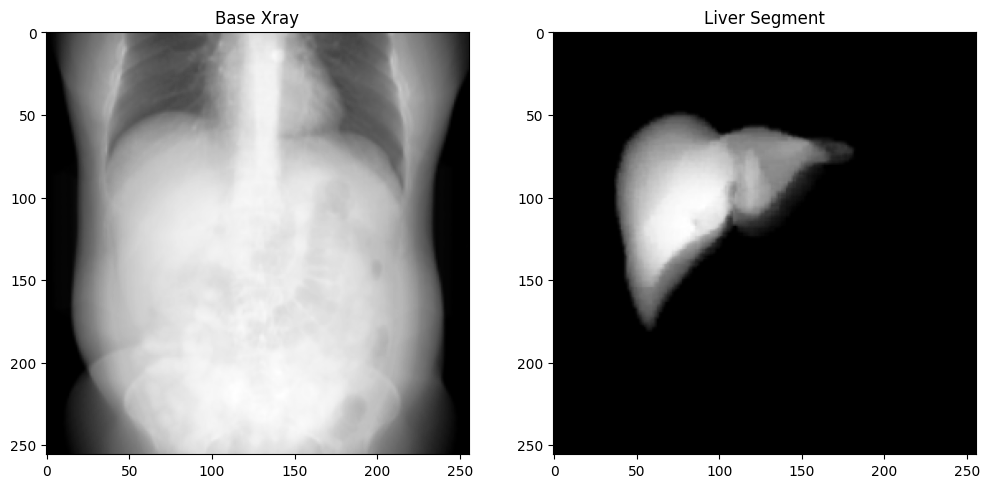

In [6]:
import matplotlib.pyplot as plt
from torchvision.transforms import v2

transform = v2.Compose(
    [v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.Resize(size=(256, 256))]
)
data = transform.forward(
    torch.tensor(np.transpose(np.load("data/AP_labels.npy"), (1, 0, 2, 3)))
)

images = np.transpose(data.numpy(), (0, 2, 3, 1))

base = np.sum(images, axis=0)
example = images[44]

f, axarr = plt.subplots(1, 2, figsize=(12, 12))

axarr[0].set_title("Base Xray")
axarr[0].imshow(1.0 - base, cmap="Greys")
axarr[1].set_title("Liver Segment")
axarr[1].imshow(1.0 - example, cmap="Greys")

pass

In [7]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, data):
        self.base = torch.sum(data, dim=0)
        self.images = data
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        image = self.images[idx]
        return image, self.base, idx+1

dataset = ImageDataset(data=data[1:, ...])

In [8]:
from utilities import ImageGaussianDistribution


def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    """
    Function that returns the learning rate for the specific step, used in defining the scheduler:
        scheduler = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
        )
    """
    if step < warmup_steps:
        return step / warmup_steps

    if use_cos_decay:
        decay_steps = total_steps - warmup_steps
        decay_step = step - warmup_steps

        decay_step = min(decay_step, decay_steps)

        cosine_decay = 0.5 * (1 + math.cos(math.pi * decay_step / decay_steps))
        return cosine_decay
    else:
        return 1.0


def training(model, dataloader, epochs=20, lr=5e-4, drop_prob=0.1, warmup_steps=0, use_cos_decay=True, device="cuda"):
    gaussian = ImageGaussianDistribution(image_shape=(1, 256, 256))
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(
            step, epochs * len(dataloader), warmup_steps, use_cos_decay
        ),
    )

    train_losses = []
    for i in range(epochs):
        model.train()
        training_loss = 0.0
        batch_count = 0

        for j, (Z, Y, C) in enumerate(dataloader):
            B, Ch, H, W = Z.shape

            Z = Z.to(device=device)
            Y = Y.to(device=device)

            T = torch.rand(size=(B, 1)).to(device=device)
            epsilon = gaussian.sample(B, device=device)

            X = T.reshape(B, Ch, 1, 1) * Z + (1.0 - T).reshape(B, Ch, 1, 1) * epsilon
            target = Z - epsilon

            mask = torch.floor(torch.rand(size=(B,)) + (1.0 - drop_prob))
            C = (C * mask).int().to(device=device)

            #############################

            out = model(X, Y, C, T)
            loss = torch.nn.functional.mse_loss(out, target)

            training_loss += loss.item()
            print(f"Epoch {i}; Batch {j} : training loss={loss.item():.4f}")

            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()

            batch_count += 1

        training_loss /= batch_count
        print(f"Epoch {i}; : training loss={training_loss:.4f}")
        train_losses.append(training_loss)

    return train_losses

In [9]:
model = DiffusionTransformer(
    d_emb=512,
    num_blocks=8,
    num_heads=4,
    mlp_ratio=4.0,
    dropout=0.1,
    img_size=256,
    patch_size=8,
    in_channels=1,
    num_classes=118,
).to(device='cuda')

print(f"Total Model Parameters: ~{sum(p.numel() for p in model.parameters()) / 1e6:.2f}mil")

Total Model Parameters: ~35.36mil


In [ ]:
losses = training(
    model=model,
    dataloader=DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        pin_memory=True,
    ),
    epochs=20,
    warmup_steps=0, 
    use_cos_decay=True
)

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("Epochs")
ax.set_ylabel("Training Loss")

fig.show(warn=False)

Epoch 0; Batch 0 : training loss=1.6207


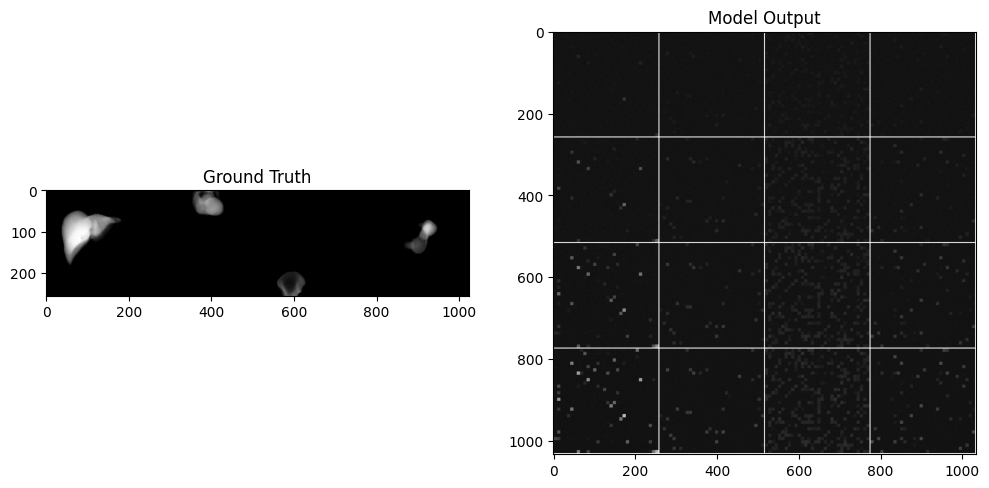

In [ ]:
from torchvision import utils

guide_w = 4.0
n_steps = 64
dt = 1 / n_steps

L = [44, 28, 30, 86]
X = ImageGaussianDistribution(image_shape=(1, 256, 256)).sample(4, device="cuda")
C = torch.tensor(L).int().to(device="cuda")
Y = dataset.base.unsqueeze(0).expand(4, 1, 256, 256).to(device="cuda")

model.eval()
outputs = []

with torch.no_grad():
    for i in range(n_steps):
        T = torch.ones(4, 1, device="cuda") * (i * dt)

        out = model(X, Y, torch.zeros_like(C, device="cuda").int(), T)
        out_label = model(X, Y, C, T)

        U = (1 - guide_w) * out + guide_w * out_label
        X = X + dt * U

        if (i + 1) % (n_steps // 4) == 0:
            out = 1.0 - X.detach().cpu()
            outputs.append(out)

ground_truth = np.concatenate([1.0 - images[lb] for lb in L], axis=1)
model_outputs = utils.make_grid(
    tensor=torch.cat(outputs, dim=0), nrow=4, normalize=True
)[0].numpy()

f, axarr = plt.subplots(1, 2, figsize=(12, 12))
axarr[0].set_title("Ground Truth")
axarr[0].imshow(ground_truth, cmap="Greys")
axarr[1].set_title("Model Output")
axarr[1].imshow(model_outputs, cmap="Greys")

pass